# 英雄联盟比赛胜负预测

## 项目概述

英雄联盟（LoL）是美国游戏开发商Riot Games（2011年由腾讯收购）开发和发行的一款多人在线战斗竞技游戏。

在游戏中，玩家扮演一个"召唤师"角色，每个召唤师控制一个拥有独特技能的"英雄"，并与一组其他玩家或电脑控制的英雄战斗。游戏的目标是摧毁对方的防御塔和基地。

召唤者峡谷是英雄联盟中最受欢迎的地图，在这种地图类型中，两队五名玩家竞争摧毁一个被称为基地的敌人建筑，这个建筑由敌人的队伍和一些防御塔护卫。每个队伍都希望保卫自己的建筑，同时摧毁对方的建筑。这些主要包括:

1. Towers（防御塔）：每支队伍总共有11座防御塔
2. Inhibitor（水晶）：每条道有一个水晶
3. Elemental Drakes/Elder Dragon（大龙/远古龙）
4. Rift Herald（峡谷先锋）
5. Baron Nasho（纳什男爵）
6. Nexus（基地）

英雄联盟最具争议的元素之一，就是其严重的滚雪球效应。许多职业选手接受赛后采访时都提到其输赢都因为“滚雪球”，我们研究各方面各指标的数据，来看这些因素的发展是否真的影响了比赛的成败。在这个项目中，我们分析了5万多场英雄联盟的排名比赛，并尝试使用决策树算法来根据已有输入属性预测比赛胜负。

## 数据集概述

这是一个收集了超过50000个从游戏英雄联盟排位游戏，字段主要包含以下数据：

- Game ID：游戏ID
- Creation Time：创建时间
- Game Duration (in seconds)：游戏持续时间（秒）
- Season ID：赛季ID
- Winner (1=team1, 2=team2)：获胜队伍
- First Baron, dragon, tower, blood, inhibitor and Rift Herald (1 = team1, 2 = team2, 0 = none)：第一条纳什男爵，大龙，塔，一血，水晶，峡谷先锋
- Champions and summoner spells for each team (Stored as Riot's champion and summoner spell IDs)：每只队伍选择的英雄和召唤术
- The number of tower, inhibitor, Baron, dragon and Rift Herald kills each team has：塔，水晶，男爵，大龙和峡谷先锋击杀数
- The 5 bans of each team (Again, champion IDs are used)：每个队伍的禁用英雄

## 数据读入和预处理

In [25]:
# 数据整理
import numpy as np 
import pandas as pd 

# 可视化
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py 
import plotly.graph_objs as go 

# 建模
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report 

In [24]:
# 设置
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100)   

plt.style.use('seaborn') 

In [58]:
# 读入数据
df = pd.read_csv('./archive/games.csv')
df.head() 

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,2,8,12,4,432,3,4,96,4,7,11,11,6,112,4,14,11,1,2,3,0,92,40,69,119,141,104,11,4,498,4,7,122,6,4,238,14,4,412,4,3,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,1,119,7,4,39,12,4,76,4,3,10,4,14,35,4,11,10,4,0,2,1,51,122,17,498,19,54,4,12,25,4,14,120,11,4,157,4,14,92,4,7,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,0,18,4,7,141,11,4,267,3,4,68,4,12,38,12,4,8,1,1,1,0,117,40,29,16,53,69,4,7,412,14,4,126,4,12,24,4,11,22,7,4,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,0,57,4,12,63,4,14,29,4,7,61,4,1,36,11,4,9,2,1,2,0,238,67,516,114,31,90,14,4,19,11,4,412,4,3,92,4,14,22,4,7,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,0,19,4,12,29,11,4,40,4,3,119,4,7,134,7,4,9,2,1,3,0,90,64,412,25,31,37,3,4,59,4,12,141,11,4,38,4,12,51,4,7,3,0,0,1,0,86,11,201,122,18


In [59]:
df.shape

(51490, 61)

## 数据可视化

### 目标变量分布

In [60]:
df.winner.value_counts() 

1    26077
2    25413
Name: winner, dtype: int64

In [61]:
# 饼图
trace0 = go.Pie(labels=df['winner'].value_counts().index, 
                values=df['winner'].value_counts().values,
                hole=0.5,
                opacity=0.9,
                marker=dict(line=dict(color='white', width=1.3))
               ) 
layout = go.Layout(title='目标变量winner分布')

data = [trace0]
fig = go.Figure(data, layout)
py.offline.plot(fig, filename='./html/整体获胜情况分布.html')

'./html/整体获胜情况分布.html'

数据集一共有51490条记录，其中1队获胜的次数为26077次，占比50.6%，2队获胜的次数为25413次，占比49.4%。不存在样本不平衡的情况。

### 游戏时长分布

In [71]:
df['game_duration'] = round(df['gameDuration'] / 60) 

# 选择数据
x1 = df[df['winner'] == 1]['game_duration']
x2 = df[df['winner'] == 2]['game_duration'] 

# 直方图
trace0 = go.Histogram(x=x1, bingroup=25, name='team1', opacity=0.9)
trace1 = go.Histogram(x=x2, bingroup=25, name='team2', opacity=0.9)  

layout = go.Layout(title='比赛游戏时长分布') 

data = [trace0, trace1] 
fig = go.Figure(data, layout)
py.offline.plot(fig, filename='./html/游戏时长分布.html')

'./html/游戏时长分布.html'

从直方图可以看出，游戏时长大致服从正态分布，其中最短的游戏时长为3分钟，3分钟是游戏重开的时间点，最长的游戏时长是79分钟。中间50%的时长在26~36分钟之间。

### 一血对获胜的影响

In [139]:
def plot_bar_horizontal(input_col: str, target_col: str, title_name: str):
    cross_table = round(pd.crosstab(df[input_col], df[target_col], normalize='index')*100, 2)

    # 索引
    index_0 = cross_table.columns.tolist()[0] 
    index_1 = cross_table.columns.tolist()[1] 
    
    # 绘图轨迹
    trace0 = go.Bar(x=cross_table[index_0].values.tolist(),
                    y=cross_table.index.tolist(), 
                    name=index_0,
                    orientation='h',
                    marker=dict(color='rgb(154,203,228)')
                   ) 
    trace1 = go.Bar(x=cross_table[index_1].values.tolist(),  
                    y=cross_table.index.tolist(),
                    name=index_1,
                    orientation='h',
                    marker=dict(color='rgb(191,76,81)')
                   ) 

    data = [trace0, trace1] 
    # 布局
    layout = go.Layout(title=title_name, bargap=0.4, barmode='stack')
    
    # 画布
    fig = go.Figure(data=data, layout=layout)
    # 绘图
    py.offline.plot(fig, filename=f'./html/{title_name}.html') 

In [152]:
def plot_bar_vertical(input_col: str, target_col: str, title_name: str):
    cross_table = round(pd.crosstab(df[input_col], df[target_col], normalize='index')*100, 2)

    # 索引
    index_0 = cross_table.columns.tolist()[0] 
    index_1 = cross_table.columns.tolist()[1] 
    
    # 绘图轨迹
    trace0 = go.Bar(x=cross_table.index.tolist(),
                    y=cross_table[index_0].values.tolist(),
                    name=index_0,
                    orientation='v',
                    marker=dict(color='rgb(191,76,81)')
                   ) 
    trace1 = go.Bar(x=cross_table.index.tolist(),  
                    y=cross_table[index_1].values.tolist(),
                    name=index_1,
                    orientation='v',
                    marker=dict(color='rgb(154,203,228)')
                   ) 

    data = [trace0, trace1] 
    # 布局
    layout = go.Layout(title=title_name, bargap=0.4, barmode='stack')
    
    # 画布
    fig = go.Figure(data=data, layout=layout)
    # 绘图
    py.offline.plot(fig, filename=f'./html/{title_name}.html') 

In [133]:
pd.crosstab(df['firstBlood'], df['winner'])  

winner,1,2
firstBlood,,
0,298,257
1,15532,10581
2,10247,14575


In [144]:
plot_bar_horizontal(input_col='firstBlood', target_col='winner', title_name='一血对获胜的影响')  

结论：获得一血的队伍胜率相对较高，在第一队的比赛中，首先获得一血时的胜率为59.48%，相较未获得一血的比赛高18%。在第二队的比赛中，获得一血时的胜率为58.72%，相较未获得一血的比赛高18%。

### 一塔对获胜的影响

In [88]:
pd.crosstab(df['firstTower'], df['winner']) 

winner,1,2
firstTower,,
0,628,585
1,18320,7541
2,7129,17287


In [145]:
plot_bar_horizontal(input_col='firstTower', target_col='winner', title_name='一塔对获胜的影响')  

结论：从数据来看，第一个防御塔看起来是比较有说服力的指标。在第一队的比赛中，首先摧毁一塔时队伍的胜率高达70.84%，相较未获得一塔的比赛高41.64%。在第二队的比赛中，有相近的数据表现。

### 摧毁第一个水晶对获胜的影响

In [94]:
pd.crosstab(df['firstInhibitor'], df['winner'])  

winner,1,2
firstInhibitor,,
0,3210,3066
1,20949,2105
2,1918,20242


In [146]:
plot_bar_horizontal(input_col='firstInhibitor', target_col='winner', title_name='摧毁第一个水晶对获胜的影响')  

结论：在比赛中拿到第一座水晶塔的队伍91%的情况下可以获胜，这一点在某种程度上是可以预见的，因为首先摧毁水晶塔代表队伍已经积累的足够的优势，而且水晶塔力量很强大，并且更具有价值。

### 击杀第一条男爵对获胜影响

In [97]:
pd.crosstab(df['firstBaron'], df['winner']) 

winner,1,2
firstBaron,,
0,10844,9414
1,11978,2780
2,3255,13219


In [147]:
plot_bar_horizontal(input_col='firstBaron', target_col='winner', title_name='击杀第一条男爵对获胜影响')  

结论：统计数据显示，在比赛中击杀第一条男爵有80%的胜率。

### 击杀第一条大龙对获胜的影响

In [100]:
pd.crosstab(df['firstDragon'], df['winner']) 

winner,1,2
firstDragon,,
0,1072,928
1,16937,7753
2,8068,16732


In [148]:
plot_bar_horizontal(input_col='firstDragon', target_col='winner', title_name='击杀第一条大龙对获胜的影响') 

结论：在第一个队伍中，首先击杀第一条大龙的队伍胜率在68.6%，相较未取得优先的比赛胜率高36%。

### 击杀第一条峡谷先锋对获胜的影响

In [105]:
pd.crosstab(df['firstRiftHerald'], df['winner']) 

winner,1,2
firstRiftHerald,,
0,13309,12870
1,8993,3955
2,3775,8588


In [150]:
plot_bar_horizontal(input_col='firstRiftHerald', target_col='winner', 
                    title_name='击杀第一条峡谷先锋对获胜的影响')

结论：在第一个队伍中，首先击杀第一条峡谷先锋的队伍胜率在69.45%，相较未取得优先的比赛胜率高38.92%。

### 摧毁防御塔数对获胜影响

In [158]:
df.t1_towerKills.value_counts() 

11    5945
0     5938
10    5784
9     5297
1     4428
3     4041
2     3941
8     3918
4     3361
7     3269
5     2960
6     2608
Name: t1_towerKills, dtype: int64

In [153]:
plot_bar_vertical(input_col='t1_towerKills', target_col='winner', title_name='摧毁防御塔数对获胜影响')  

结论：选择第一个队伍的摧毁防御塔数作为影响因素，可以看出，摧毁的防御塔数量越多，获胜的概率越大。当数量大于8个时，胜率大于85%。11个防御塔全部摧毁时的胜率为99.16%，当然也有8.4‰的翻盘概率。

### 摧毁水晶数对获胜影响

In [157]:
df.t1_inhibitorKills.value_counts() 

0     25732
1      9567
2      8879
3      5104
4      1584
5       423
6       137
7        43
8        11
9         6
10        4
Name: t1_inhibitorKills, dtype: int64

In [156]:
plot_bar_vertical(input_col='t1_inhibitorKills', target_col='winner', title_name='摧毁水晶数对获胜影响')  

结论：摧毁水晶的数目越多，获胜的概率越大。没有摧毁水晶的获胜概率为12.55%，摧毁一个的获胜概率为81.11%，两个为92.38%。

### 击杀男爵数对获胜影响

In [162]:
df.t1_baronKills.value_counts() 

0    34901
1    14179
2     2251
3      149
4        9
5        1
Name: t1_baronKills, dtype: int64

In [161]:
plot_bar_vertical(input_col='t1_baronKills', target_col='winner', title_name='击杀男爵数对获胜影响')  

结论：击杀男爵数越多，获胜的概率越大，击杀5条男爵的数据仅有一条，后续需要删除。

### 击杀大龙数对获胜影响

In [166]:
plot_bar_vertical(input_col='t1_dragonKills', target_col='winner', title_name='击杀大龙数对获胜影响')

结论：击杀大龙数数越多，获胜的概率越大

## 数据建模

In [167]:
# 删除时间少于15分钟和分类数较少的记录
df = df[(df['gameDuration'] >= 900) & (df['t1_baronKills'] != 5)]
print(df.shape) 

(50180, 62)


In [168]:
# 筛选建模变量
df_model = df[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
              'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills','t1_baronKills',
              't1_dragonKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills'
              ]] 
df_model.head() 

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills
0,1,2,1,1,1,1,2,11,1,2,3,5,0,0,1
1,1,1,1,1,0,1,1,10,4,0,2,2,0,0,0
2,1,2,1,1,1,2,0,8,1,1,1,2,0,0,1
3,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0
4,1,2,1,1,1,1,0,9,2,1,3,3,0,0,1


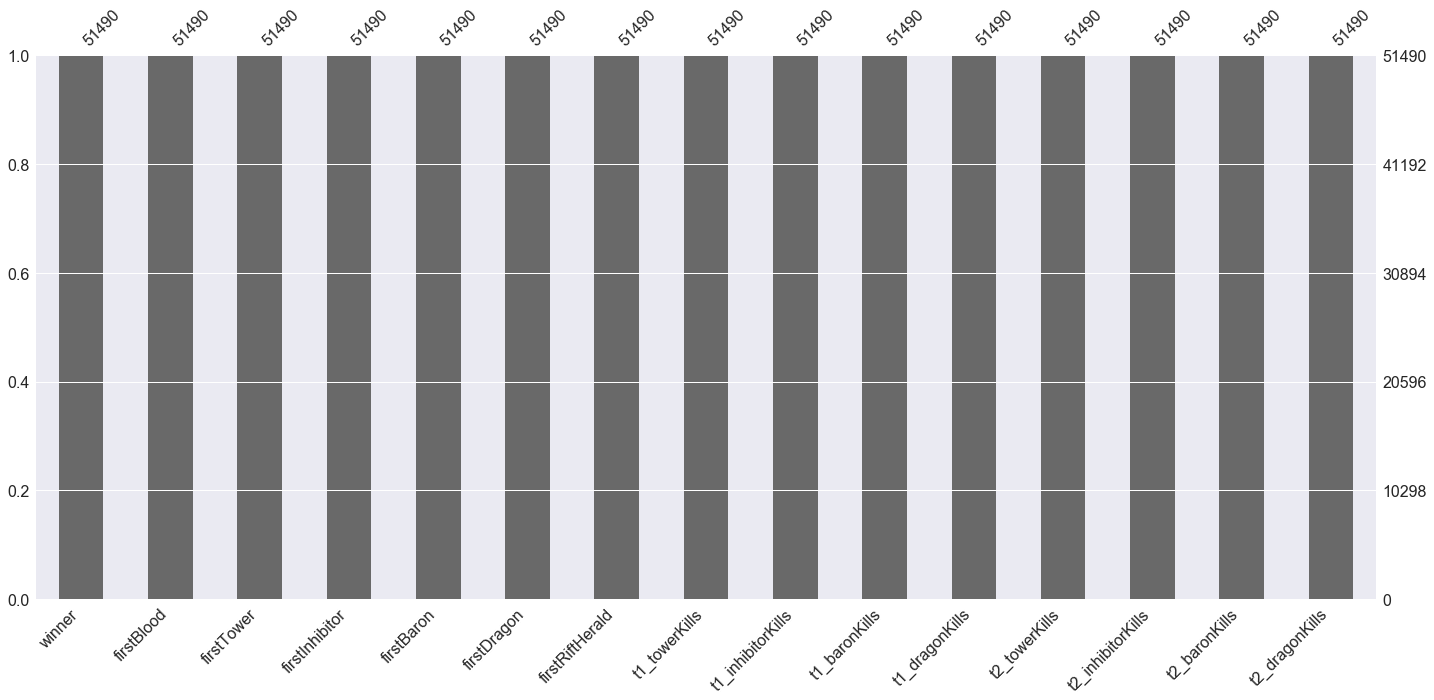

In [45]:
# 查看缺失值
import missingno as msno

msno.bar(df_model)
plt.show()  

In [170]:
# 划分训练集和测试集
x = df_model.drop('winner', axis=1)
y = df_model['winner']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(40144, 14) (10036, 14) (40144,) (10036,)


In [176]:
# 参数
parameters = {
    'splitter': ('best', 'random'),
    'criterion':('gini', 'entropy'),
    'max_depth':[*range(1, 20, 2)],
}

# 建立模型
clf = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(X_train, y_train)  

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})

In [178]:
# 输出最佳得分 
print("best score: ", GS.best_score_)
print("best param: ", GS.best_params_)

best score:  0.9770077890521407
best param:  {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}


In [180]:
# 最佳模型
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=7, splitter="best")
best_clf.fit(X_train,y_train) 
print("score:", best_clf.score(X_test,y_test))   

score: 0.9799721004384216


In [182]:
# 分类报告
y_pred = best_clf.predict(X_test) 
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print('Classification report : \n', cr) 

Classification report : 
               precision    recall  f1-score   support

           1       0.98      0.98      0.98      5077
           2       0.98      0.98      0.98      4959

    accuracy                           0.98     10036
   macro avg       0.98      0.98      0.98     10036
weighted avg       0.98      0.98      0.98     10036



Text(0.5, 1, 'confusion_matrix')

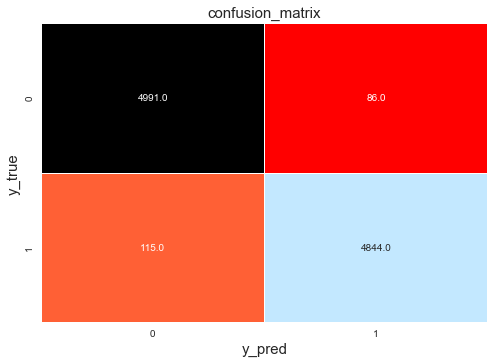

In [189]:
# 热力图
g1 = sns.heatmap(cm, annot=True, fmt=".1f", cmap="flag", linewidths=0.2, cbar=False)
g1.set_ylabel('y_true', fontdict={'fontsize': 15})
g1.set_xlabel('y_pred', fontdict={'fontsize': 15})  
g1.set_title('confusion_matrix', fontdict={'fontsize': 15})  

In [219]:
# 输出属性重要性
imp = pd.DataFrame(list(zip(X_train.columns, best_clf.feature_importances_))) 
imp.columns = ['columns', 'importances']
imp = imp.sort_values('importances', ascending=False)
imp

,columns,importances
10,t2_towerKills,0.720592
6,t1_towerKills,0.231177
7,t1_inhibitorKills,0.016769
11,t2_inhibitorKills,0.014381
2,firstInhibitor,0.010415
1,firstTower,0.001764
8,t1_baronKills,0.001608
13,t2_dragonKills,0.000973
9,t1_dragonKills,0.000742
12,t2_baronKills,0.000640


在属性的重要性排序中，击杀防御塔数量的重要性最高，其次是水晶摧毁数量、一塔、击杀龙的数量。

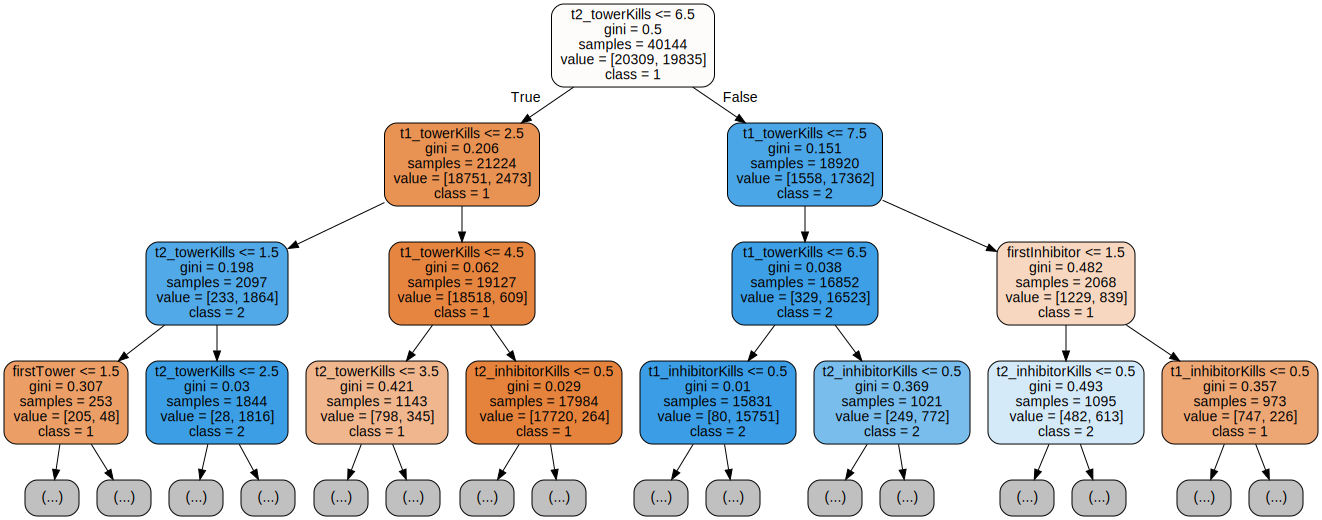

In [203]:
# 可视化
import graphviz
from sklearn import tree 

dot_data = tree.export_graphviz(decision_tree=best_clf, max_depth=3,
                                 out_file=None, 
                                 feature_names=X_train.columns,
                                 class_names=['1', '2'], 
                                 filled=True,
                                 rounded=True
                                )
graph = graphviz.Source(dot_data)
graph

## 模型预测

我们假设:

第一队拿了第一血，第一塔，第一男爵，第一条大龙和第一峡谷先锋，而第二队只拿了第一个水晶。

第一队的塔，水晶，男爵和龙杀死的数量分别是10,2,1,4和塔，水晶，男爵和龙的数量分别是7,2,1,1。

In [217]:
# 新数据
new_data = [[1, 1, 2, 1, 1, 1, 10, 2, 1, 4, 7, 2, 1, 1]]
c = best_clf.predict_proba(new_data).reshape(-1, 1) 
print("winner is :" , best_clf.predict(x1)) 
print("First team win probability is % ", list(c[0] * 100),
      "\nSecond team win probability is %:",list(c[1] * 100)) 

winner is : [1]
First team win probability is %  [89.87341772151899] 
Second team win probability is %: [10.126582278481013]


根据模型预测结果，第一队将会获胜，获胜的概率为89.87%。